## Importing Libraries

These are libraries that will be used throughout this part of the project

In [449]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import math
import os
import time
import warnings; warnings.simplefilter('ignore')
import matplotlib
import qgrid

from datetime import timedelta, datetime

qgrid.enable()

## Importing Data

### Actual Precipitation Data

There are 5 Datasets that I will use in this section of the analysis. The first of these contains the actual Precipitation data. This data has been taken directly from Met Eireann. At the moment, this data is stored in seperate files for each location. The following is a dictionary containing the 20 locations:

We will also need two functions which will be used to split the name of the location from the .csv file

In [450]:
def split_name(filename):
    return filename.split('.csv')[0]

We can merge these .csv files together by writing a function:

In [451]:
def merge_actual(date_range):
    # First we create an empty DataFrame. In this we will store the Location, Date and Precipitation amount
    df = pd.DataFrame()
    
    # Must loop through all of the 20 files and append the data to the DataFrame we have created
    path = "C:/Users/u/Dropbox/Final Year Project/Python/Untitled Folder/compare_script"
    
    for filename in os.listdir(path):
        if '.csv' in filename and filename != 'df.csv':
            try:
                # First import the csv of the location in question
                curr_df = pd.read_csv(filename,error_bad_lines=False)

                # We make sure that we are only selecting the data that we need
                curr_df['date'] = pd.to_datetime(curr_df['date'], format="%d/%m/%Y %H:%M")
                curr_df = curr_df.loc[curr_df['date'] >= pd.to_datetime(date_range[0],format="%d-%m-%Y")]
                curr_df = curr_df.loc[curr_df['date'] <= pd.to_datetime(date_range[1],format="%d-%m-%Y")]
                
                # Add a column which will hold the name of the location
                curr_df['Location'] = split_name(filename)
                
                # Rename rain column. Duplicate will be dropped later
                curr_df['Precipitation'] = pd.to_numeric(curr_df['rain'])

                # We set index of dataframe to the time and change it to datetime data type.
                curr_df = curr_df.set_index('date')
                curr_df.index = pd.to_datetime(curr_df.index)
                
                # We can then take only the columns that we need
                selected_columns = ['Location','Precipitation']
                curr_df = curr_df[selected_columns]
                
                # We can then append this locations data to the overall dataframe
                df = df.append(curr_df)
            except Exception as e:
                print(filename +  " is not a valid .csv file")
    return df

In order to use this function, we need to select a date range which I have done below:

In [452]:
date_range = ['','']
date_range[0] = pd.to_datetime("01-12-2020",format="%d-%m-%Y")
date_range[1] = pd.to_datetime("31-03-2021",format="%d-%m-%Y")

We can then create the actual DataFrame that we will use:

In [453]:
actual_df = merge_actual(date_range)

ACTUAL_DATA.csv is not a valid .csv file
Met Eireann Actual.csv is not a valid .csv file
Met Eireann Forecast.csv is not a valid .csv file
ow_forecast_data.csv is not a valid .csv file
wwo_forecast_data.csv is not a valid .csv file
wwo_forecast_data1.csv is not a valid .csv file
wwo_forecast_data2.csv is not a valid .csv file
yr_forecast_data.csv is not a valid .csv file


As can be seen below, this DataFrame simply has the Date, Location and the Precipitation actual value that Met Eireann has provided for that location. While this is useful to compare all of the locations, I will also be using the individual location data in order to make comparisons

In [454]:
actual_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Forecast Precipitation Data

In addition to the Actual Data collected from Met Eireann, we have collected Forecast Data from 4 sources. In this section, I will import these .csv files in to DataFrames also.

The 4 Sources are as follows:
- Met Eireann
- YR
- World Weather Online
- OpenWeather

In [455]:
me_forecast = pd.read_csv('df.csv')
yr_forecast = pd.read_csv('yr_forecast_data.csv')
wwo_forecast = pd.read_csv('wwo_forecast_data.csv')
ow_forecast = pd.read_csv('ow_forecast_data.csv')

## Comparing Data

One of the problems with collating all of the actual data is that it may be more efficient to compare the data individually between the 20 locations that we have collected data for. The reason for this is due to the fact that sometimes the APIs do not work properly, and do not return data. As such, we have the problem of missing data to contend with.

To deal with this, I have created a function which will remove NaN values from DataFrames:

In [456]:
def remove_nan_values(forecast_df,actual_df):
    missing_times = forecast_df.index[forecast_df['Precipitation'].isnull() == True]

    for time in missing_times:
        forecast_df = forecast_df[forecast_df.index != time]
        actual_df = actual_df[actual_df.index != time]

    return forecast_df,actual_df

Because we take forecasts 3-4 days in advance, each hour across the date_range will have multiple values. As such, it was necessary to write a function which splits the precipitation forecasts based on the dates that they were predicted in advance. The following is a function which does this:

In [457]:
def split_into_days(df,date_range):
    
    # Create an empty array 
    dataframe_collection = {}

    # Create the dataframes for each array. We can have lead days of 5
    for lead_day in range(0,4):
        dataframe_collection[lead_day] = pd.DataFrame(columns=["Location","Date of Prediction","Date","Precipitation"])
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = pd.DatetimeIndex(df['Date']).tz_localize(None)
    
    # We take only the forecast data which is in the given date range
    df = df.loc[df['Date'] >= date_range[0]]
    df = df.loc[df['Date'] <= date_range[1]]
    
    for hour in df['Date'].unique():
        for location in df['Location'].unique():

            temp_df = df[df['Date'] == hour]
            temp_df = temp_df[temp_df['Location'] == location]

            for day in temp_df['Date of Prediction']:
                current = temp_df[temp_df['Date of Prediction'] == day]
                date_of_prediction = pd.to_datetime(str(current['Date'].values[0]).split("T")[0],format="%Y-%m-%d")
                date = pd.to_datetime(str(day).split(" ")[0],format="%Y-%m-%d")

                difference = abs((date-date_of_prediction).days)


                dataframe_collection[difference] = dataframe_collection[difference].append(current)
    
    return dataframe_collection

We can then divide each of the data found in these forecasts into their respective lead days

In [458]:
me_forecast

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Calculates the intersection between two lists

In [459]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [460]:
me_collection = split_into_days(me_forecast,date_range)
ow_collection = split_into_days(ow_forecast,date_range)
wwo_collection = split_into_days(wwo_forecast,date_range)
yr_collection = split_into_days(yr_forecast,date_range)

The next step in this process if to sort the values and set the index for each of these as the date

In [461]:
for i in me_collection:
    # Re arrange some of these columns
    me_collection[i] = me_collection[i].sort_values(by=['Date','Location'])
    me_collection[i] = me_collection[i].set_index('Date')
    print(len(me_collection[i]['Location'].unique()))
    
    yr_collection[i] = yr_collection[i].sort_values(by=['Date','Location'])
    yr_collection[i] = yr_collection[i].set_index('Date')
    
    ow_collection[i] = ow_collection[i].sort_values(by=['Date','Location'])
    ow_collection[i] = ow_collection[i].set_index('Date')
    
    wwo_collection[i] = wwo_collection[i].sort_values(by=['Date','Location'])
    wwo_collection[i] = wwo_collection[i].set_index('Date')

20
20
20
20


The following is a function that will make 2 dataframes that can be used in order to compare the precipitation data for various locations. It works by comparing the length of both the actual and the prediction values in order to ensure that we are only comparing data that exists in both forecast and actual.

In [462]:
def comparison(actual,forecast):
    # Take the unique date values that appear in the indexes of both of these columns
    actual_date_values = actual.index.unique()
    forecast_date_values = forecast.index.unique()
    
    # Calculate the intersection of these values
    inter = intersection(actual_date_values,forecast_date_values)
    
    output_actual = actual[actual.index.isin(inter)]
    output_forecast = forecast[forecast.index.isin(inter)]
    
    return output_actual,output_forecast

The next function will calculate the actual vs predicted precipitation across the date range in question.

In [463]:
def actual_vs_predicted(actual,forecast):
    actual,forecast = comparison(actual,forecast)
    
    
    output_df = actual.groupby(by=['Location']).sum()
    output_df['Forecasted'] = (forecast.groupby(by=['Location']).sum())['Precipitation']
    output_df[' % Difference'] = output_df['Forecasted']/output_df['Precipitation']
    
    return output_df

In [464]:
me_avp = actual_vs_predicted(actual_df,me_collection[1])
wwo_avp =actual_vs_predicted(actual_df,wwo_collection[1])
yr_avp =actual_vs_predicted(actual_df,yr_collection[1])
ow_avp = actual_vs_predicted(actual_df,ow_collection[1])

Compares between these services

In [465]:
actual_comp = pd.DataFrame(columns=['actual','yr','met_eireann','ow','wwo'])
  
actual_comp['yr'] = yr_avp['Forecasted']
actual_comp['met_eireann'] = me_avp['Forecasted']
actual_comp['ow'] = ow_avp['Forecasted']
actual_comp['actual'] = ow_avp['Precipitation']
actual_comp['wwo'] = wwo_avp['Forecasted']

In [466]:
actual_comp

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Text(0.5, 0, 'Location')

<Figure size 864x576 with 0 Axes>

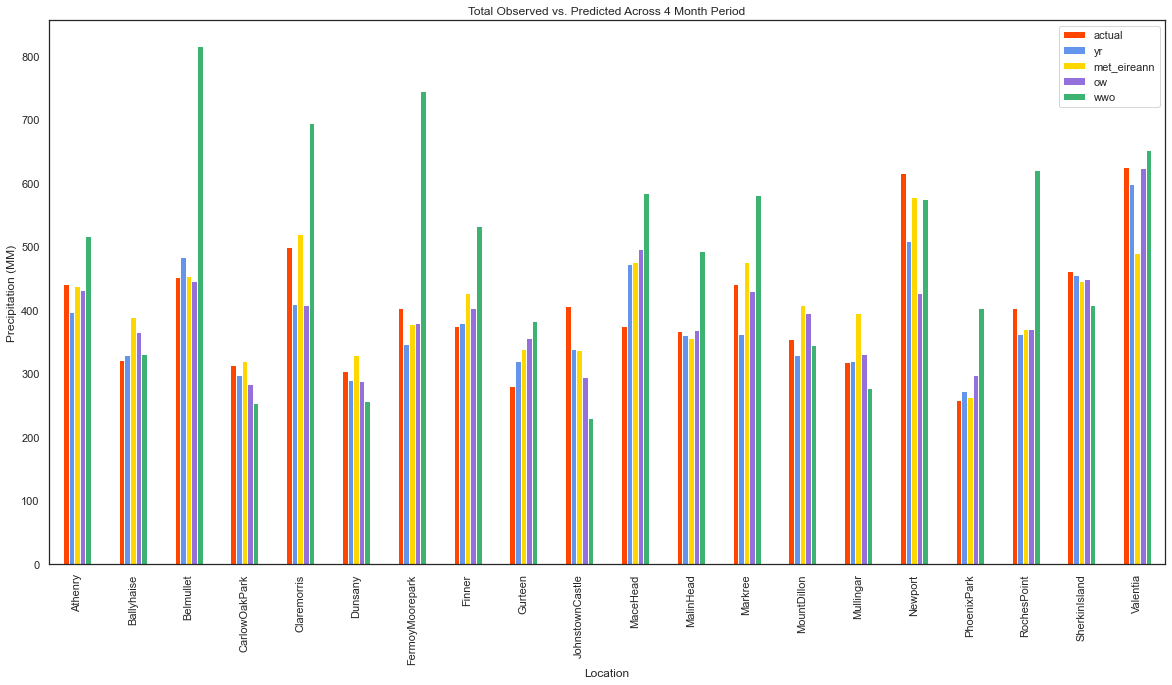

In [467]:
sns.set_style("white")
plt.figure(figsize=(12,8))
ax = actual_comp.plot.bar(figsize=(20,10),color=['orangered','cornflowerblue','gold','mediumpurple','mediumseagreen'])
ax.set_title("Total Observed vs. Predicted Across 4 Month Period")
ax.set_ylabel("Precipitation (MM)")
ax.set_xlabel("Location")

Need a daily comparison function in order to get the daily differences for each location

In [468]:
def daily_actual_vs_forecasted(actual,forecast,location):
    # Get comparable datasets
    actual,forecast = comparison(actual,forecast)
    
    # Create a DataFrame and give it a title
    columns = ['Forecast','Actual','Difference']
    daily_df = pd.DataFrame(columns=columns)
    daily_df.style.set_caption("Daily for " + str(location))
    
    # Calculate the number of days in question
    num_days = actual.index.max()-actual.index.min()
    
    # Only select data from location that we requested
    actual = actual[actual['Location'] == location]
    forecast = forecast[forecast['Location'] == location]
    
    grouped_actual = actual['Precipitation'].groupby(actual.index.date).sum()
    grouped_forecast = forecast['Precipitation'].groupby(forecast.index.date).sum()
    
    for i in range(0,len(grouped_actual.index)):
        try:
            daily_actual = grouped_actual[i]
            daily_forecast = grouped_forecast[i]
            daily_difference = daily_forecast-daily_actual
            daily_df = daily_df.append({'Forecast':float(daily_forecast),'Actual':float(daily_actual),
                                        'Difference':float(daily_difference)},ignore_index=True)
        except Exception as e:
            print(e)
            
    return daily_df

In [469]:
def return_data(dataframe,lead_day):
    output = pd.DataFrame(columns =['Location','Difference'])
    
    for location in dataframe[0]['Location'].unique():
        temp = daily_actual_vs_forecasted(actual_df,dataframe[lead_day],location)
        
        for i in range(0,len(temp)):
            output = output.append({'Location':location,'Difference':float(temp.iloc[i]['Difference'])},ignore_index=True)
    
    return output

Takes any values that are huge outliers. These are errors

In [470]:
def reduce_outliers(data):   
    output = pd.DataFrame()

    for location in data['Location'].unique():
        
        temp = data[data['Location'] == location]
        temp = temp[(np.abs(stats.zscore(temp['Difference'])) < 4)]
        
        output = output.append(temp)
                
    return output

In [471]:
wwo_data = reduce_outliers(return_data(wwo_collection,1))
me_data = reduce_outliers(return_data(me_collection,1))
ow_data = reduce_outliers(return_data(ow_collection,1))
yr_data = reduce_outliers(return_data(yr_collection,1))

index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 103
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is

Text(0.5, 1.0, 'Met Eireann - Box Plot of Difference in Predicted vs. Observed')

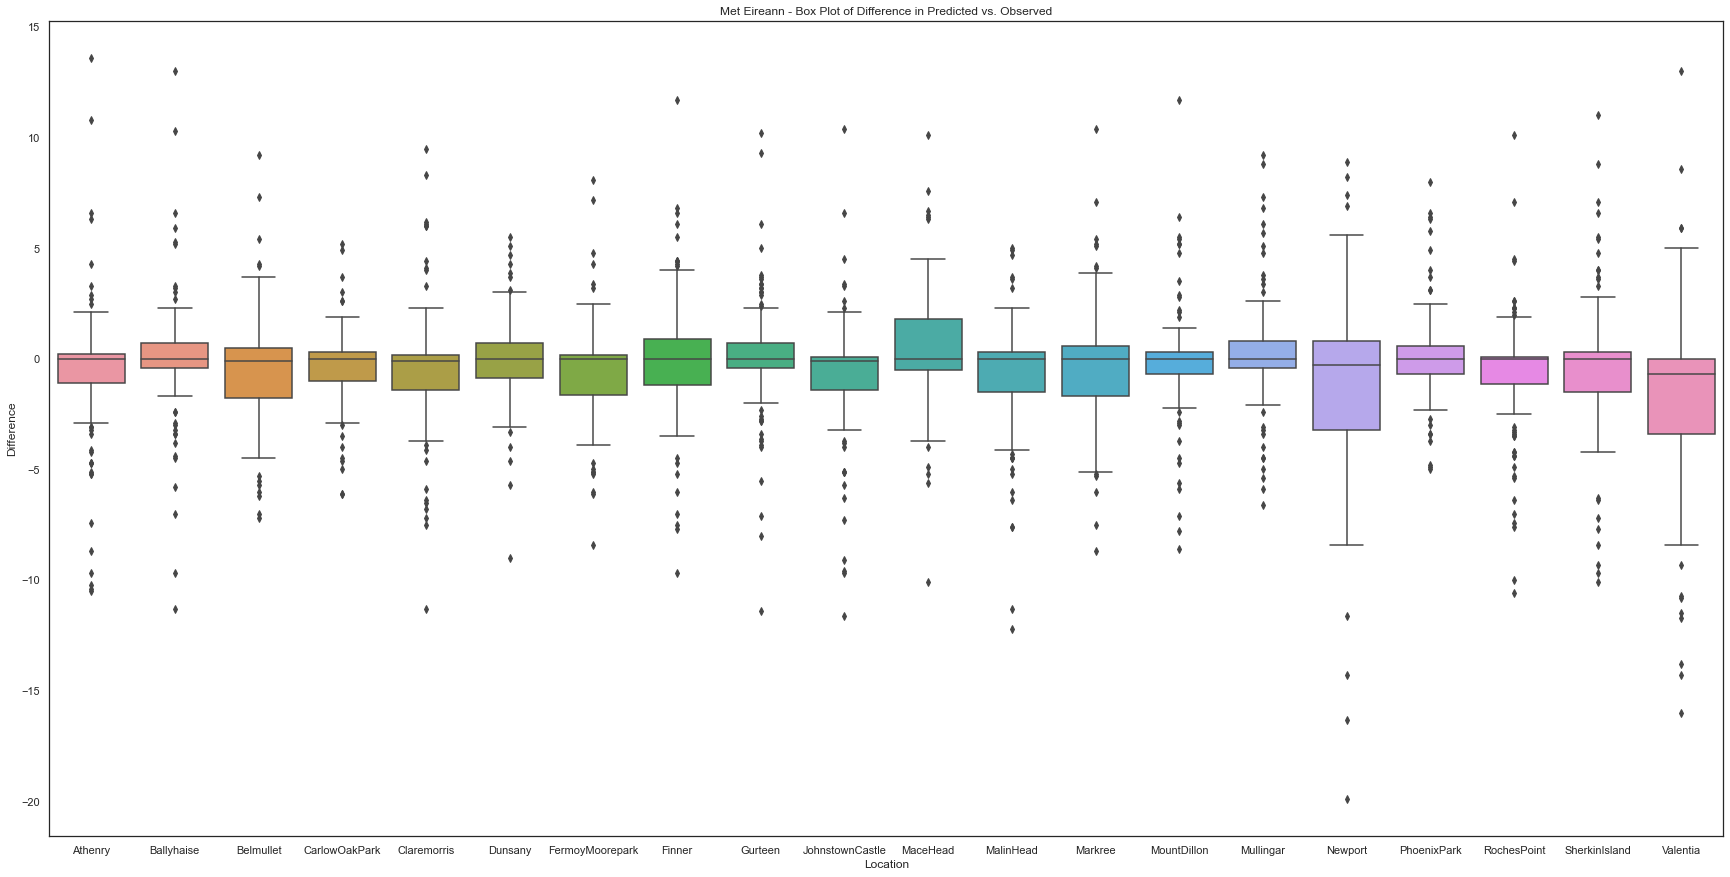

In [472]:
fig = plt.figure(1, figsize=(30,15))
ax = sns.boxplot(x='Location',y='Difference',data=me_data)
ax.set_title("Met Eireann - Box Plot of Difference in Predicted vs. Observed")

Text(0.5, 1.0, 'YR - Box Plot of Difference in Predicted vs. Observed')

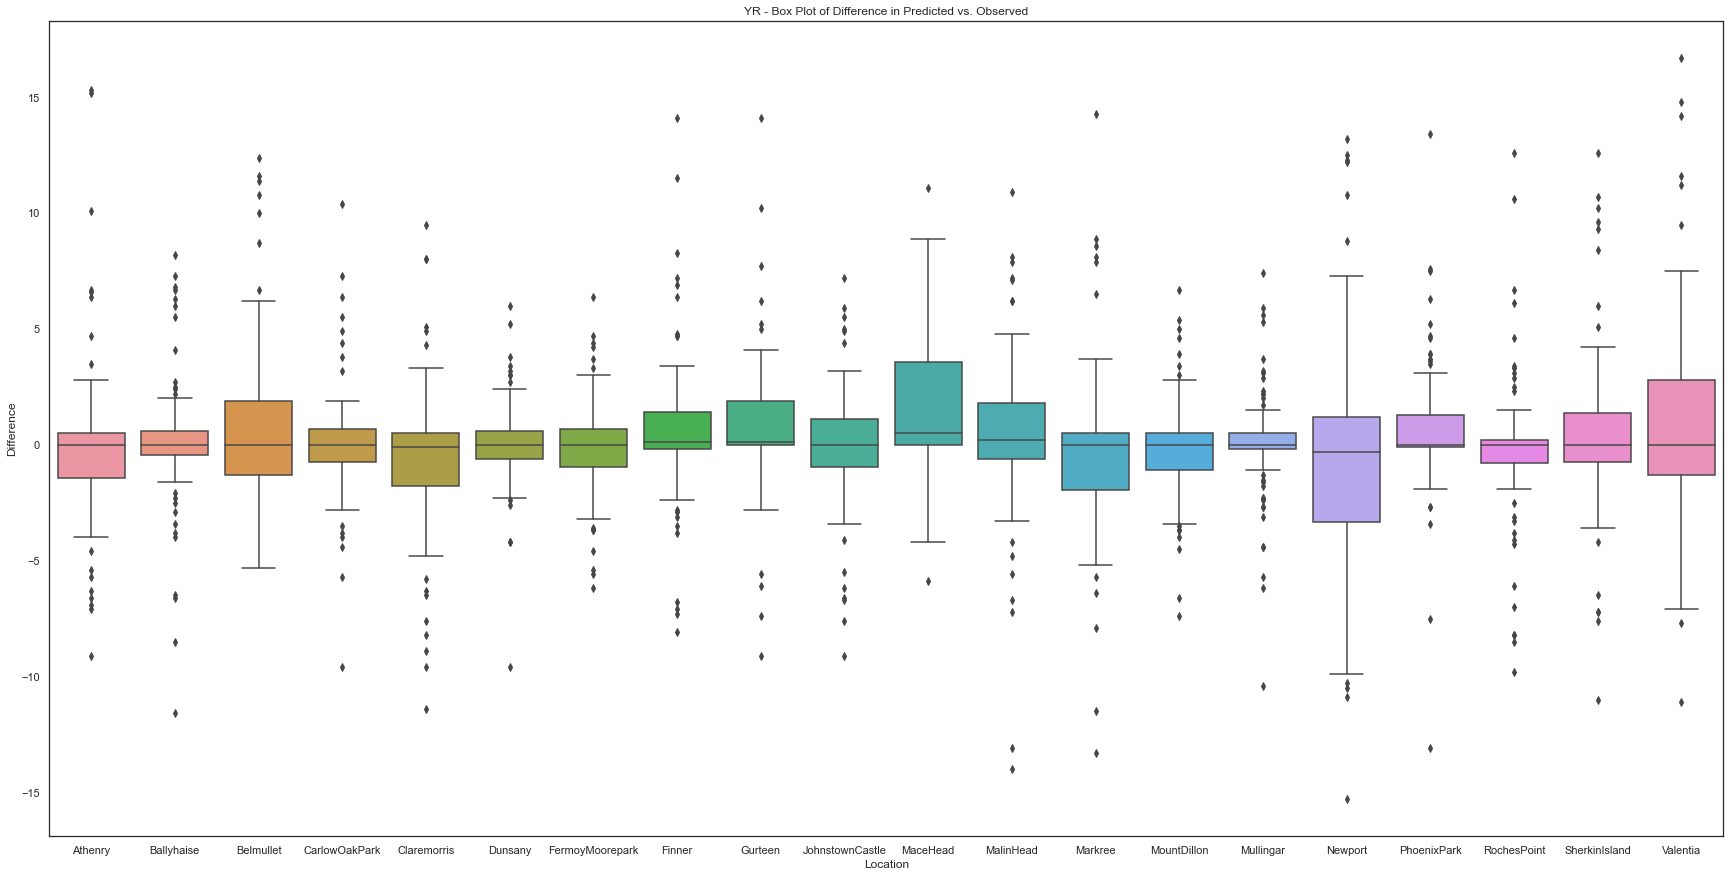

In [473]:
fig = plt.figure(1, figsize=(30,15))
ax = sns.boxplot(x='Location',y='Difference',data=yr_data)
ax.set_title("YR - Box Plot of Difference in Predicted vs. Observed")

Text(0.5, 1.0, 'OpenWeather - Box Plot of Difference in Predicted vs. Observed')

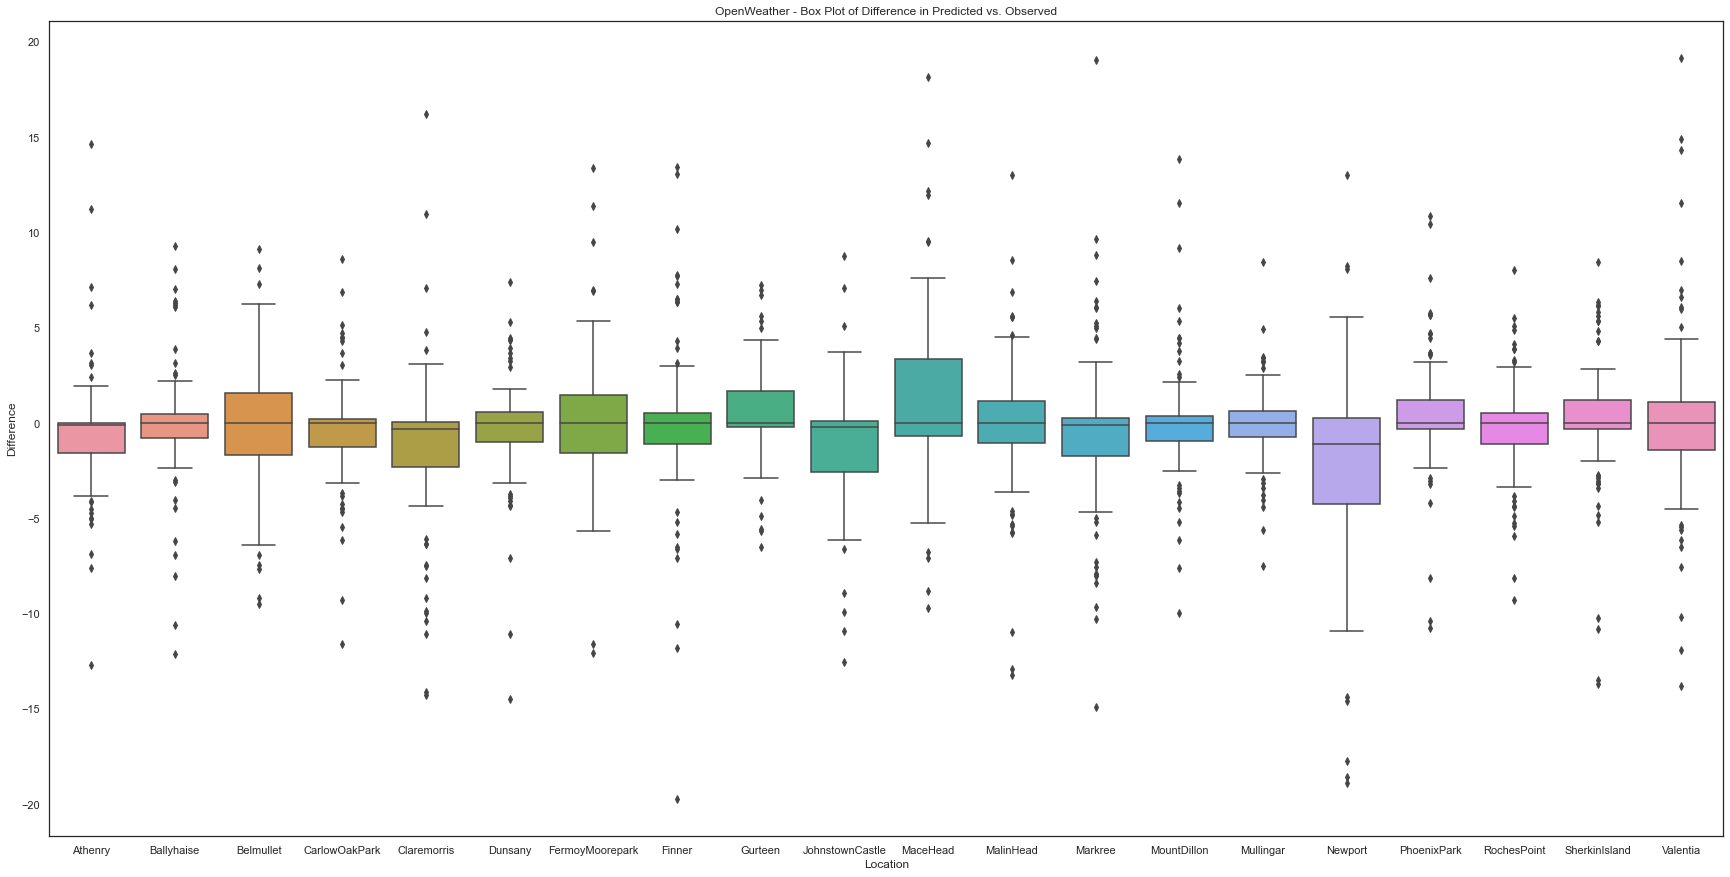

In [474]:
fig = plt.figure(1, figsize=(30,15))
ax = sns.boxplot(x='Location',y='Difference',data=ow_data)
ax.set_title("OpenWeather - Box Plot of Difference in Predicted vs. Observed")

Text(0.5, 1.0, 'World Weather Online - Box Plot of Difference in Predicted vs. Observed')

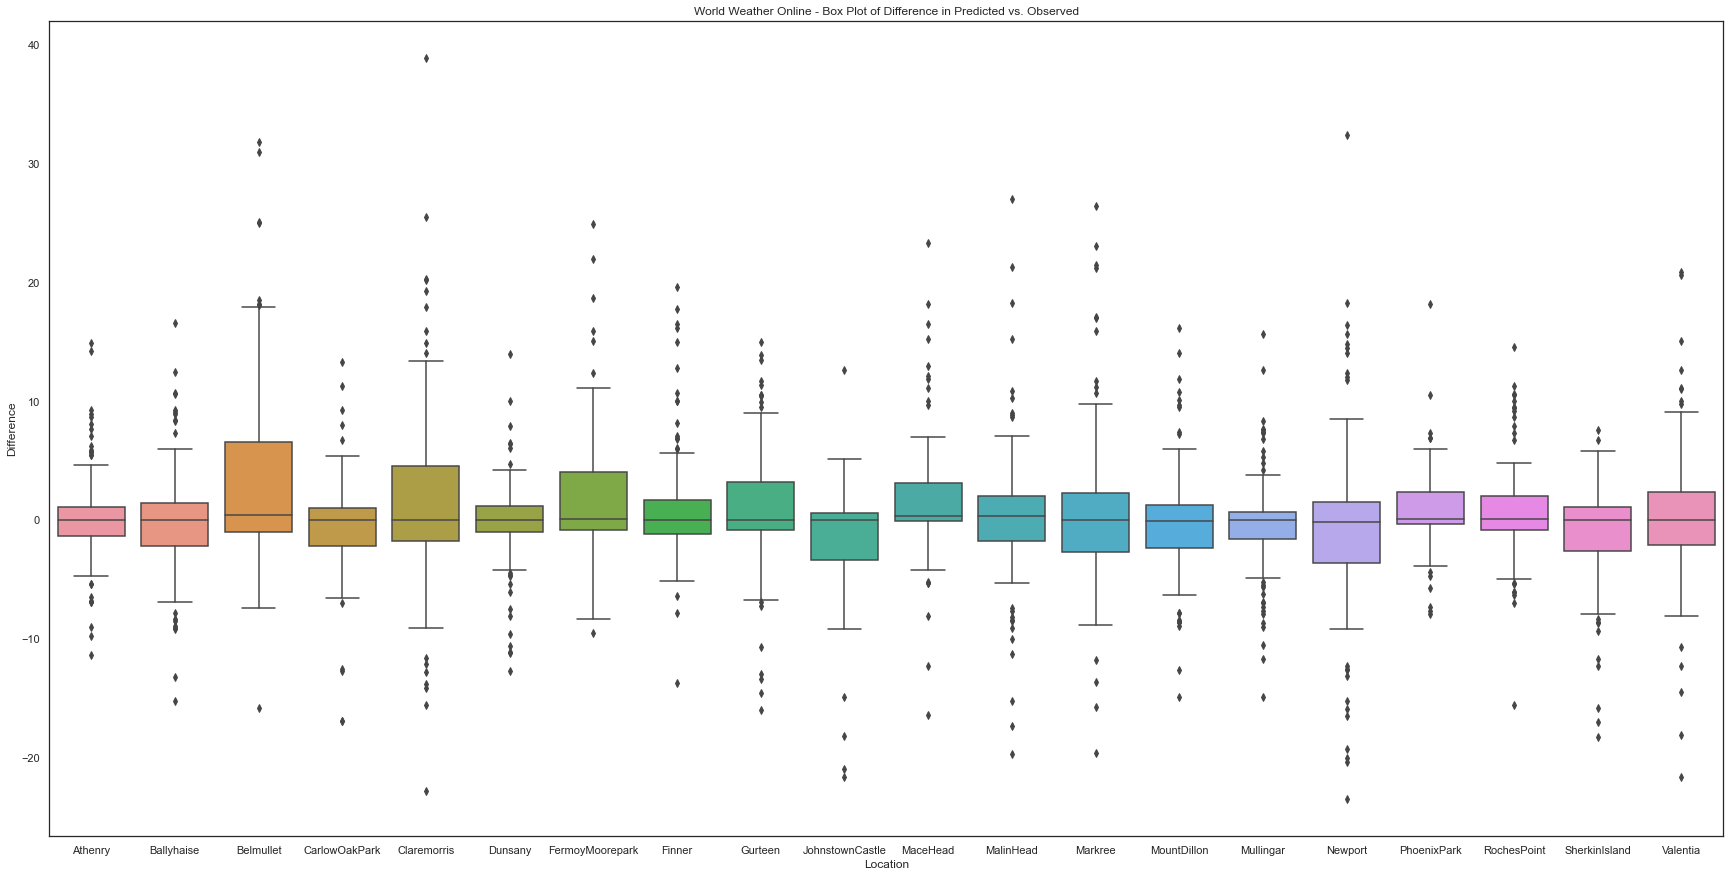

In [475]:
fig = plt.figure(1, figsize=(30,15))
ax = sns.boxplot(x='Location',y='Difference',data=wwo_data)
ax.set_title("World Weather Online - Box Plot of Difference in Predicted vs. Observed")

Creates a dataframe which can be visualised using boxplots

In [476]:
# Create a collection of dataframes to 
location_difference_df = {}
for i in range(0,20):
    location_difference_df[i] =pd.DataFrame()


index = 0
    
for location in wwo_data['Location'].unique():
    temp_wwo = wwo_data[wwo_data['Location'] == location]
    temp_ow = ow_data[ow_data['Location'] == location]
    temp_me = me_data[me_data['Location'] == location]
    temp_yr = yr_data[yr_data['Location'] == location]
    
    temp_wwo['Service'] = 'WWO'
    temp_ow['Service'] = 'OW'
    temp_me['Service'] = 'ME'
    temp_yr['Service'] = 'YR'
    
    location_difference_df[index] = location_difference_df[index].append(temp_wwo)
    location_difference_df[index] = location_difference_df[index].append(temp_ow)
    location_difference_df[index] = location_difference_df[index].append(temp_me)
    location_difference_df[index] = location_difference_df[index].append(temp_yr)
    


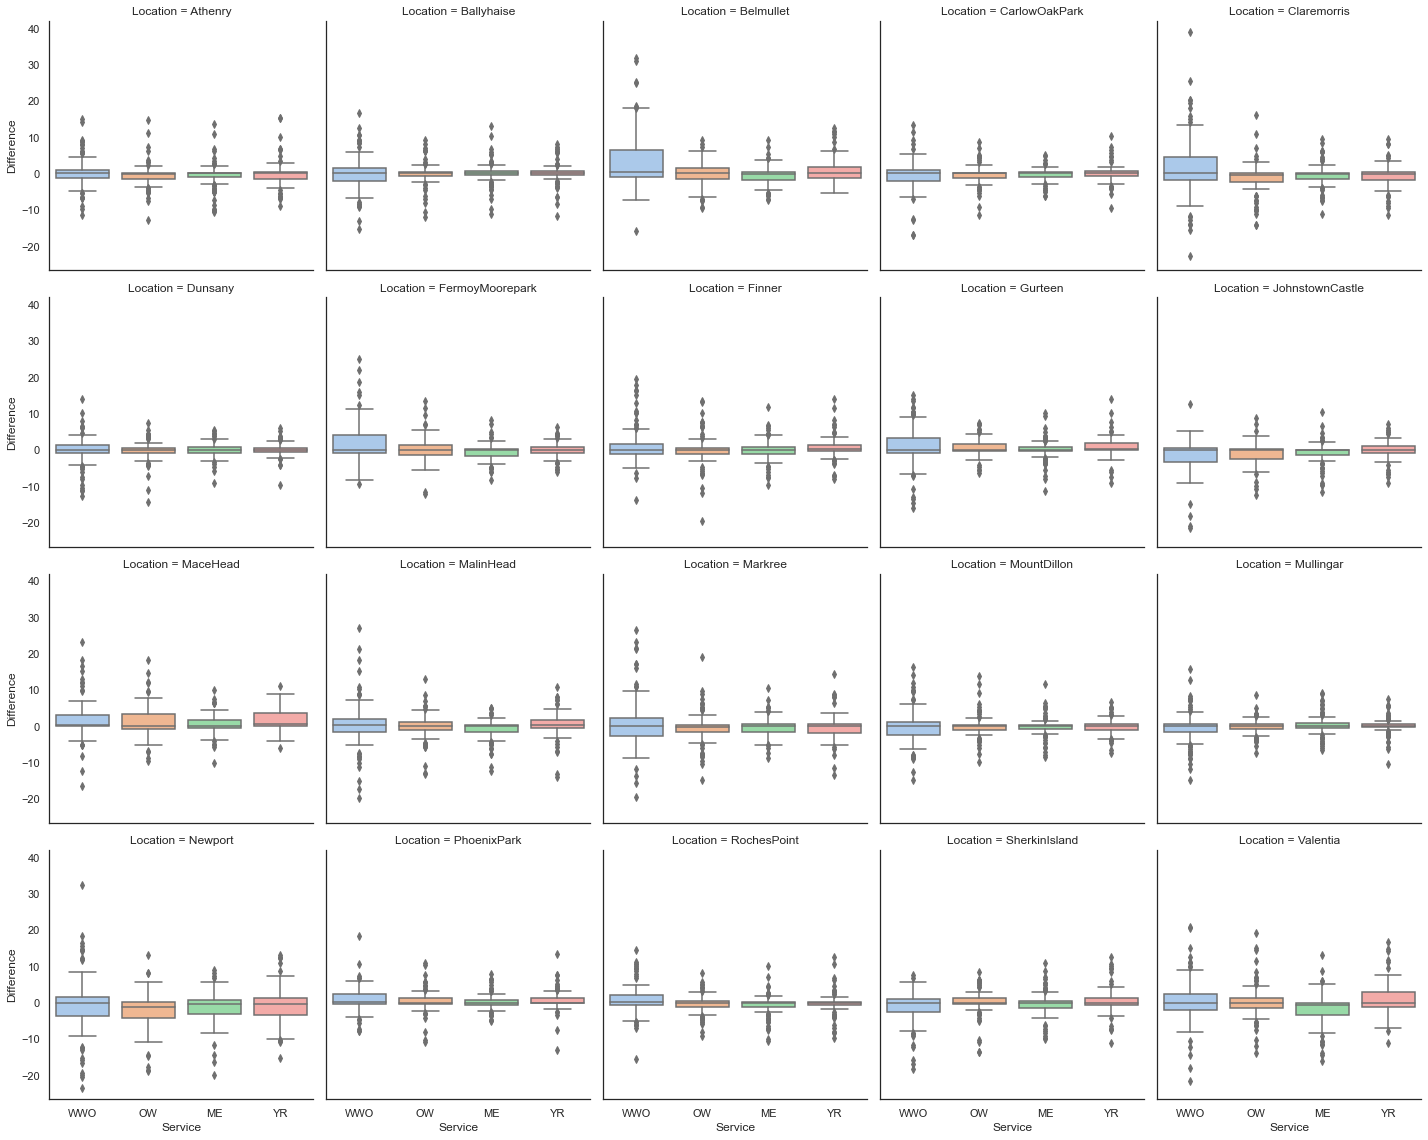

In [477]:
g = sns.FacetGrid(location_difference_df[0], col="Location", col_wrap=5, height=4,margin_titles = True,legend_out=True)
g.map(sns.boxplot, "Service", "Difference",palette='pastel')


Text(0.5, 1.0, 'Boxplot of Overall Data')

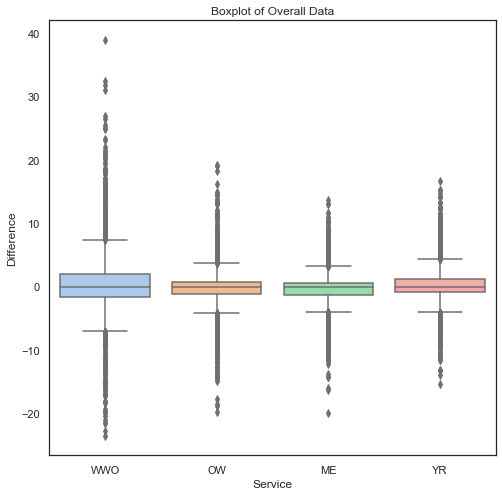

In [478]:
fig, ax = plt.subplots(figsize=(8,8))
t = sns.boxplot(data=location_difference_df[0],x="Service",y="Difference",palette='pastel')
ax.set_title("Boxplot of Overall Data")

In [479]:
mean = location_difference_df[0].groupby('Service').mean()

In [480]:
mean['Lead Day'] = [1,1,1,1]

Manually add 2 Day Difference values for easy of plotting

In [481]:
mean = mean.reset_index()

In [482]:
mean = mean.append({'Service':'ME','Difference':-0.68829,'Lead Day': 2},ignore_index = True)
mean = mean.append({'Service':'OW','Difference':-0.09494,'Lead Day': 2},ignore_index = True)
mean = mean.append({'Service':'WWO','Difference':0.43574,'Lead Day': 2},ignore_index = True)
mean = mean.append({'Service':'YR','Difference':0.45303,'Lead Day': 2},ignore_index = True)

In [483]:
mean

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

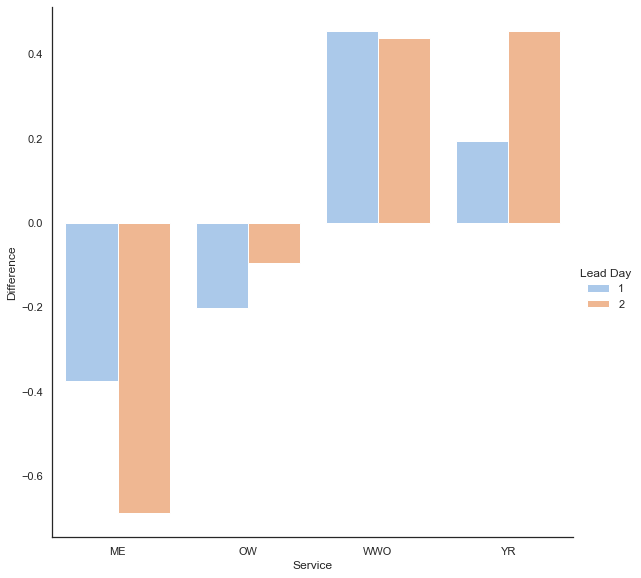

In [484]:
g = sns.catplot(data=mean,kind='bar',x='Service',y='Difference', hue='Lead Day',height=8,palette = 'pastel')


### RMSE

In [485]:
def root_mean_squared(data):
    
    sum_ = 0
    
    for i in range(0,len(data)):
        sum_ = sum_ + (data['Difference'].iloc[i]**2)
        
    
    
    return math.sqrt(sum_/len(data))

In [486]:
root_mean_squared(yr_data)

3.452661763990081

In [487]:
root_mean_squared(me_data)

3.0405067432825637

In [488]:
root_mean_squared(wwo_data)

5.916713164524511

In [489]:
root_mean_squared(ow_data)

3.7415893533215105

In [490]:
rmse_df = pd.DataFrame(columns=['Service', 'RMSE'])

rmse_df = rmse_df.append({'Service':'YR','RMSE':root_mean_squared(yr_data)},ignore_index = True)
rmse_df = rmse_df.append({'Service':'ME','RMSE':root_mean_squared(me_data)},ignore_index = True)
rmse_df = rmse_df.append({'Service':'OW','RMSE':root_mean_squared(ow_data)},ignore_index = True)
rmse_df = rmse_df.append({'Service':'WWO','RMSE':root_mean_squared(wwo_data)},ignore_index = True)

In [491]:
rmse_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Text(0.5, 1.0, 'Irish Data - Root Mean Squared Error')

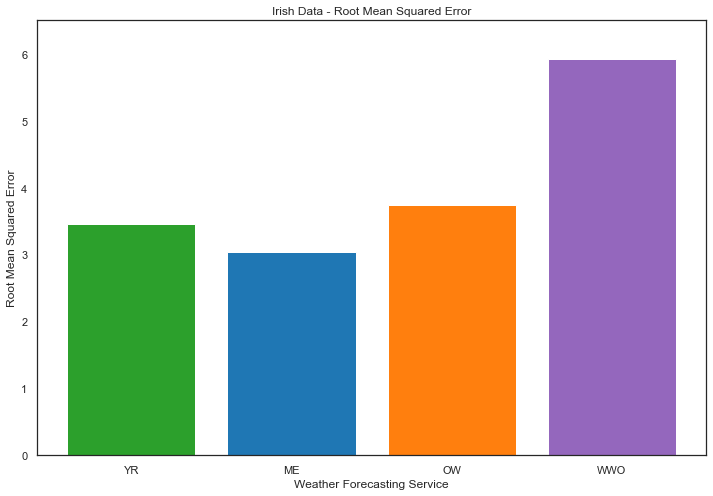

In [492]:
fig, ax = plt.subplots(figsize=(12,8))
test = ax.bar(rmse_df['Service'],rmse_df['RMSE'],color=['tab:green','tab:blue','tab:orange','tab:purple'])
ax.set_ylim(0,6.5)
ax.set_ylabel('Root Mean Squared Error')
ax.set_xlabel('Weather Forecasting Service')
ax.set_title("Irish Data - Root Mean Squared Error")

In [493]:
wwo_collection[1]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [494]:
wwo_collection[1].to_csv('WWO_1LEADDAY_FORECAST.CSV')

In [495]:
me_collection[1].to_csv('ME_1LEADDAY_FORECAST.CSV')
ow_collection[1].to_csv('OW_1LEADDAY_FORECAST.CSV')
yr_collection[1].to_csv('YR_1LEADDAY_FORECAST.CSV')

In [496]:
actual_df.to_csv('ACTUAL_DATA.csv')

In [497]:
total_df = pd.DataFrame()

for i in range(1,4):
    temp_wwo = reduce_outliers(return_data(wwo_collection,i))
    temp_ow = reduce_outliers(return_data(me_collection,i))
    temp_me = reduce_outliers(return_data(ow_collection,i))
    temp_yr = reduce_outliers(return_data(yr_collection,i))
    

    temp_wwo['Lead Day'] = i
    temp_ow['Lead Day'] = i
    temp_me['Lead Day'] = i
    temp_yr['Lead Day'] = i
    
    temp_wwo['Service'] = 'WWO'
    temp_ow['Service'] = 'OW'
    temp_me['Service'] = 'ME'
    temp_yr['Service'] = 'YR'

    total_df = total_df.append(temp_wwo)
    total_df = total_df.append(temp_ow)
    total_df = total_df.append(temp_me)
    total_df = total_df.append(temp_yr)
    


index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 103
index 103 is out of bounds for axis 0 with size 103
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 103
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is out of bounds for axis 0 with size 102
index 103 is out of bounds for axis 0 with size 102
index 102 is

index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 83 is out of bounds for axis 0 with size 83
index 82 is out of bounds for axis 0 with size 82
index 83 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 83 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 83 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 83 is out of bounds for axis 0 with size 82
index 93 is out of bounds for axis 0 with size 93
index 93 is out of bounds for axis 0 with size 93
index 93 is out of bounds for axis 0 with size 93
index 93 is out of bounds for axis 0 with size 93


AttributeError: 'Index' object has no attribute 'date'

In [ ]:
total_df['Lead_Dat'()

In [ ]:
g = sns.FacetGrid(total_df, col="Lead Day", col_wrap=5, height=8,margin_titles = True,legend_out=True)
g.map(sns.boxplot, "Service", "Difference",palette='pastel')